# Poleward Heat Transport

`mom6_tools.polar_heat_transport` collection of functions for computing and plotting poleward heat transport.

The goal of this notebook is the following:

1) server as an example on to compute polar heat transport from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [1]:
%matplotlib inline
from mom6_tools.poleward_heat_transport import  *
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.ClimoGenerator import ClimoGenerator
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from datetime import datetime, date
import yaml
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
RUNDIR = dcase.get_value('RUNDIR')
print('Run directory is:', RUNDIR)
print('Casename is:', dcase.casename)

Run directory is: /glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.004/run
Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.004


In [5]:
# create an empty class object
class args:
  pass

args.case_name = dcase.casename
args.start_date = '0020-01-01'
args.end_date = '0030-12-31'
args.savefigs = False

In [6]:
# Load the grid
grd = dcase.grid
depth = grd.depth_ocean
# remove Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, verbose=False)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [7]:
cluster = NCARCluster(project='P93300612')
cluster.scale(2)
cluster

In [8]:
client = Client(cluster)
print(cluster.dashboard_link)
client

https://jupyterhub.ucar.edu/dav/user/gmarques/proxy/33573/status


Client Scheduler: tcp://128.117.181.209:43190 Dashboard: https://jupyterhub.ucar.edu/dav/user/gmarques/proxy/33573/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
print('\n Reading monthly (hm_*) dataset...')
# load data
variables = ['T_ady_2d', 'T_diffy_2d']
%time ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.hm_*.nc', \
                     chunks={'time': 12}, parallel=True)[variables]


 Reading monthly (hm_*) dataset...
CPU times: user 849 ms, sys: 64.4 ms, total: 914 ms
Wall time: 9.91 s


In [10]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date)).load()


 Selecting data between 0020-01-01 and 0030-12-31...
CPU times: user 87.8 ms, sys: 76.9 ms, total: 165 ms
Wall time: 824 ms


In [11]:
print('\n Computing time mean...')
%time ds_sel = ds_sel.mean('time').load()


 Computing time mean...
CPU times: user 29.3 ms, sys: 6.2 ms, total: 35.5 ms
Wall time: 34.4 ms


In [12]:
# release workers
client.close(); cluster.close()

In [13]:
stream = True
# create a ndarray subclass
class C(np.ndarray): pass

varName = 'T_ady_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_sel[varName].values)
  tmp = tmp[:].filled(0.)
  advective = tmp.view(C)
  advective.units = ds[varName].units
else:
  raise Exception('Could not find "T_ady_2d" in ds')

varName = 'T_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds_sel[varName].values)
  tmp = tmp[:].filled(0.)
  diffusive = tmp.view(C)
  diffusive.units = ds[varName].units
else:
  diffusive = None
  warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

varName = 'T_lbm_diffy'
if varName in ds.variables:
  tmp = numpy.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).sum('z_l').mean('time').data)
  tmp = tmp[:].filled(0.)
  diffusive = diffusive + tmp.view(C)
else:
  warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')

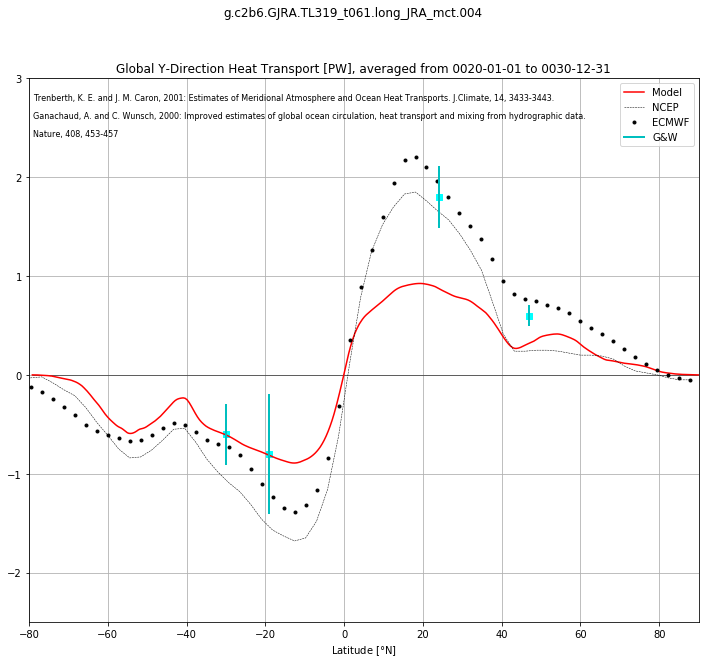

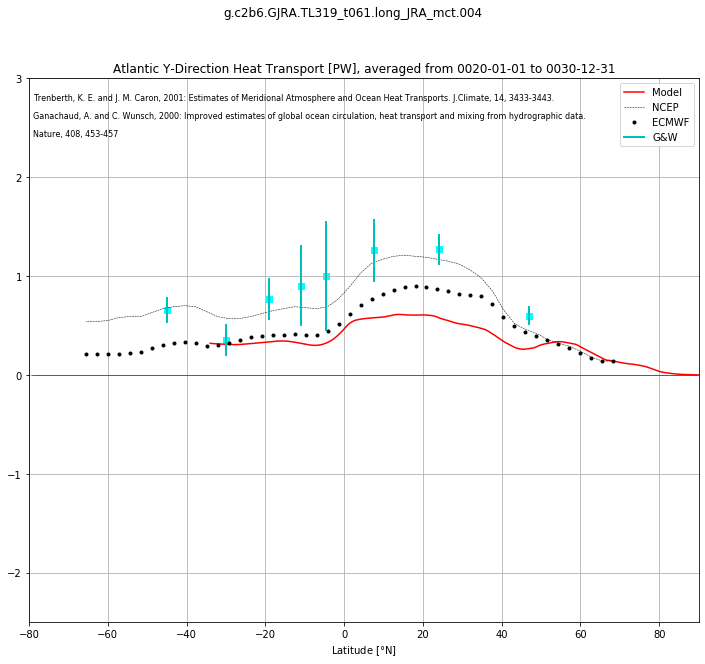

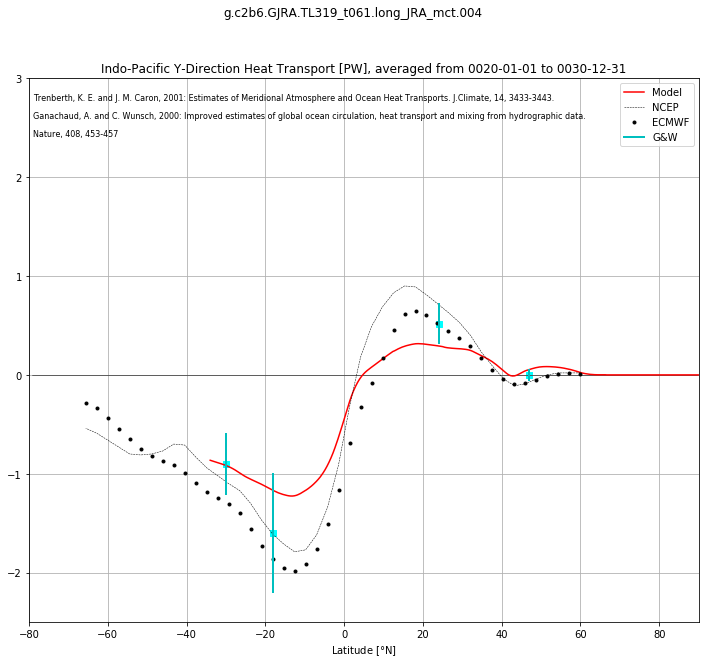

In [14]:
%matplotlib inline
# plot model vs obs
plt_heat_transport_model_vs_obs(advective, diffusive, basin_code, grd, args)  